In [1]:
import ray
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ray import tune, air

from rl_trading.simulation.env import StockExchangeEnv0
from rl_trading.data.indicators import *

In [2]:
state_config = {
        'market_state': ['vwap'],
        'technical_indicators': [
            (RPC, {}, '1min'),
            (EMA, dict(timeperiod=5, normalize=True), '1min'),
            (EMA, dict(timeperiod=13, normalize=True), '1min'),
            (RSI, dict(timeperiod=7, normalize=True), '1min'),
            (BBANDS, dict(timeperiod=10), '1min'),
            (EMA, dict(timeperiod=20, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1h'),
            (RSI, dict(timeperiod=14, normalize=True), '1h'),
            (BBANDS, dict(timeperiod=20), '1h'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1d'),
            (EMA, dict(timeperiod=200, normalize=True), '1d'),
            (RSI, dict(timeperiod=14, normalize=True), '1d'),
            (BBANDS, dict(timeperiod=20), '1d'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1d'),
        ]}

In [15]:
env = StockExchangeEnv0(
    sim_config={'max_steps': 120},
    state_config=state_config,
    _n_days=1,
    seed=42
)

# Seed 52: 7 Oct, 2022 00:39:00 AM
env.reset()
done = False
reward_total = 0
while not done:
    current_idx = env.current_idx
    current_price = env.price_data['1min'][current_idx]
    next_price = env.price_data['1min'][current_idx + 1]
    if next_price > current_price:
        action = 1
    elif next_price < current_price:
        action = 2
    else:
        action = 0
    state, reward, done, _, _ = env.step(action)
    reward_total += reward

baseline_return = reward_total
print(baseline_return)

206.08981530180426


In [86]:
for n_days in [1, 2, 3, 7, 14, 30, 90, 180, 365]:
    idxs = np.linspace(288000, 2792281 - 1440 - 1, n_days, dtype=int)
    rewards = []
    for idx in idxs:
        env = StockExchangeEnv0(state_config=state_config, _idxs_range=[idx])

        env.reset()
        done = False
        reward_total = 0
        while not done:
            current_idx = env.current_idx
            current_price = env.price_data['1min'][current_idx]
            next_price = env.price_data['1min'][current_idx + 1]
            if next_price > current_price:
                action = 1
            elif next_price < current_price:
                action = 2
            else:
                action = 0
            state, reward, done, _, _ = env.step(action)
            reward_total += reward
        rewards.append(reward_total)
    print(f'Rewards for {n_days} days: {np.mean(rewards)}')

Rewards for 1 days: 3524.0318073657327
Rewards for 2 days: 2448.108463408131
Rewards for 3 days: 2196.5172885797583
Rewards for 7 days: 4578.045584805158
Rewards for 14 days: 5281.126865380163
Rewards for 30 days: 5046.436411228319
Rewards for 90 days: 5209.73555386386
Rewards for 180 days: 5561.167910107364
Rewards for 365 days: 4924.183543495301


## A3C

In [31]:
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.algorithms.apex_dqn import ApexDQNConfig
from ray.rllib.algorithms.r2d2 import R2D2Config

from ray.rllib.algorithms.a2c import A2CConfig
from ray.rllib.algorithms.a3c import A3CConfig
from ray.rllib.algorithms.sac import SACConfig
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.impala import ImpalaConfig

from ray.tune.registry import register_env

ray.shutdown()
ray.init()

register_env('StockExchangeEnv-v0', lambda config: StockExchangeEnv0(**config))

dqn_config = (
    DQNConfig()
    .training(num_steps_sampled_before_learning_starts=1440)
    .rollouts(num_rollout_workers=1, num_envs_per_worker=1)
    .resources(num_gpus=1)
    .environment(env='StockExchangeEnv-v0',
                 env_config={
                     'state_config': state_config,
                     '_idxs_range': [288000]
                 })
    .reporting(min_sample_timesteps_per_iteration=1440)
    .evaluation(
        evaluation_interval=20,
        evaluation_duration=1,
        evaluation_config={'explore': False}
    )
)

ppo_config = (
    PPOConfig()
    .training(
        vf_clip_param=2500,
        entropy_coeff=0.1,
        entropy_coeff_schedule=[[0, 0.1], [50000, 0.01], [100000, 0.001], [150000, 0.0]])
    .rollouts(num_rollout_workers=1, num_envs_per_worker=1)
    .resources(num_gpus=1)
    .environment(env='StockExchangeEnv-v0',
                 env_config={
                    'state_config': state_config,
                     '_idxs_range': [288000]
                 })
    .reporting(min_sample_timesteps_per_iteration=1440)
    .evaluation(
        evaluation_interval=20,
        evaluation_duration=1,
        evaluation_config={'explore': False}
    )
)

a3c_config = (
    A3CConfig()
    .rollouts(num_rollout_workers=1, num_envs_per_worker=1)
    .resources(num_gpus=1)
    .environment(env='StockExchangeEnv-v0',
                 env_config={
                    'state_config': state_config,
                     '_idxs_range': [288000]
                 })
    .reporting(min_sample_timesteps_per_iteration=1440)
    .evaluation(
        evaluation_interval=20,
        evaluation_duration=1,
        evaluation_config={'explore': False}
    )
)

sac_config = (
    SACConfig()
    .rollouts(num_rollout_workers=1, num_envs_per_worker=1)
    .resources(num_gpus=1)
    .environment(env='StockExchangeEnv-v0',
                 env_config={
                    'state_config': state_config,
                     '_idxs_range': [288000]
                 })
    .reporting(min_sample_timesteps_per_iteration=1440)
    .evaluation(
        evaluation_interval=20,
        evaluation_duration=1,
        evaluation_config={'explore': False}
    )
)

impala_config = (
    ImpalaConfig()
    .rollouts(num_rollout_workers=1, num_envs_per_worker=1)
    .resources(num_gpus=1)
    .environment(env='StockExchangeEnv-v0',
                 env_config={
                    'state_config': state_config,
                     '_idxs_range': [288000]
                 })
    .training(vtrace_drop_last_ts=False,
              replay_proportion=0.1)
    .reporting(min_sample_timesteps_per_iteration=1440)
    .evaluation(
        evaluation_interval=20,
        evaluation_duration=1,
        evaluation_config={'explore': False}
    )
)

r2d2_config = (
    R2D2Config()
    .rollouts(num_rollout_workers=1, num_envs_per_worker=1)
    .resources(num_gpus=1)
    .environment(env='StockExchangeEnv-v0',
                 env_config={
                    'state_config': state_config,
                     '_idxs_range': [288000]
                 })
    .training(model={'use_lstm': True, 'max_seq_len': 80},
              replay_buffer_config={'replay_burn_in': 40},
              zero_init_states=False)
    .reporting(min_sample_timesteps_per_iteration=1440)
    .evaluation(
        evaluation_interval=20,
        evaluation_duration=1,
        evaluation_config={'explore': False}
    )
)

configs = {
    'DQN': dqn_config.build(),
    'PPO': ppo_config.build(),
    'A3C': a3c_config.build(),
    'R2D2': r2d2_config.build(),
    'SAC': sac_config.build(),
    'IMPALA': impala_config.build(),
}

2023-06-12 21:10:04,315	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/gymnasium/envs/registration.py:555: UserWarning: WARN: The environment StockExchangeEnv-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
(RolloutWorker pid=3179422) 2023-06-12 21:10:13,273	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/gymnasium/envs/registration.py:555: UserWarning: WARN: The environment StockExchangeEnv-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
(RolloutWorker pid=3179871) 2023-06-12 21:10:21,826	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environmen

In [23]:
from IPython import display

In [36]:
from ray.tune.logger import pretty_print
from collections import namedtuple
from concurrent.futures import ThreadPoolExecutor, as_completed

Metrics = namedtuple('Metrics', ['mean', 'min', 'max', 'p25', 'p75'])

def calculate_metrics(returns):
    mean_return, min_return, max_return, p25_return, p75_return = np.mean(returns), np.min(returns), np.max(returns), np.percentile(returns, 25), np.percentile(returns, 75)
    return Metrics(mean_return, min_return, max_return, p25_return, p75_return)

def plot_train_progress(train_history, eval_history, baseline=None):
    plt.clf()
    plt.close()
    display.clear_output(wait=True)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for i, (algo_name, history) in enumerate(train_history.items()):
        train_mean_ret = [r.mean for r in history]
        train_min_ret = [r.min for r in history]
        train_max_ret = [r.max for r in history]
        train_p25_ret = [r.p25 for r in history]
        train_p75_ret = [r.p75 for r in history]

        axes[0].set_title('Train')
        axes[0].fill_between(np.arange(len(train_mean_ret)), train_min_ret, train_max_ret, alpha=0.25, color=f'C{i}')
        axes[0].fill_between(np.arange(len(train_mean_ret)), train_p25_ret, train_p75_ret, alpha=0.1, color=f'C{i}')
        axes[0].plot(train_mean_ret, label=algo_name, color=f'C{i}')

        axes[0].set_xlabel('Iteration')
        axes[0].set_ylabel('Return')
        axes[0].legend()

    for i, (algo_name, history) in enumerate(eval_history.items()):
        eval_mean_ret = [r.mean for r in history]
        eval_min_ret = [r.min for r in history]
        eval_max_ret = [r.max for r in history]
        eval_p25_ret = [r.p25 for r in history]
        eval_p75_ret = [r.p75 for r in history]

        axes[1].set_title('Eval')
        axes[1].fill_between(np.arange(len(eval_mean_ret)), eval_min_ret, eval_max_ret, alpha=0.25, color=f'C{i}')
        axes[1].fill_between(np.arange(len(eval_mean_ret)), eval_p25_ret, eval_p75_ret, alpha=0.1, color=f'C{i}')
        axes[1].plot(eval_mean_ret, label=algo_name, color=f'C{i}')

        # if baseline:
        #     axes[1].axhline(baseline, color='C1', linestyle='--', label='Baseline')

        axes[1].set_xlabel('Iteration')
        axes[1].set_ylabel('Return')
        axes[1].legend()
    display.display(fig)

def run_single_experiment(algo, algo_name, n_iterations):
    train_history, eval_history = {algo_name: []}, {algo_name: []}
    for i in range(n_iterations):
        train_result = algo.train()
        eval_result = algo.evaluate()

        train_returns = train_result['hist_stats']['episode_reward']
        eval_returns = eval_result['evaluation']['hist_stats']['episode_reward']
        train_metrics = calculate_metrics(train_returns)
        eval_metrics = calculate_metrics(eval_returns)
        train_history[algo_name].append(train_metrics)
        eval_history[algo_name].append(eval_metrics)

        plot_train_progress(train_history, eval_history)

def run_multiple_experiments(configs, n_iterations):
    train_history, eval_history = {alg: [] for alg in configs}, {alg: [] for alg in configs}
    for i in range(n_iterations):
        with ThreadPoolExecutor(max_workers=5) as executor:
            futures = {
                executor.submit(alg.train): alg_name
                for alg_name, alg in configs.items()
            }
            train_results = {}
            for future in as_completed(futures):
                train_results[futures[future]] = future.result()
            train_returns = {alg_name: r['hist_stats']['episode_reward'] for alg_name, r in train_results.items()}

            futures = {
                executor.submit(alg.evaluate): alg_name
                for alg_name, alg in configs.items()
            }
            eval_results = {}
            for future in as_completed(futures):
                eval_results[futures[future]] = future.result()
            eval_returns = {alg_name: r['evaluation']['hist_stats']['episode_reward']
                            for alg_name, r in eval_results.items()}

        train_metrics = {alg_name: calculate_metrics(train_returns[alg_name]) for alg_name in train_returns}
        eval_metrics = {alg_name: calculate_metrics(eval_returns[alg_name]) for alg_name in eval_returns}

        for alg_name, metrics in train_metrics.items():
            train_history[alg_name].append(metrics)
        for alg_name, metrics in eval_metrics.items():
            eval_history[alg_name].append(metrics)

        plot_train_progress(train_history, eval_history, baseline=baseline_return)

## A3C

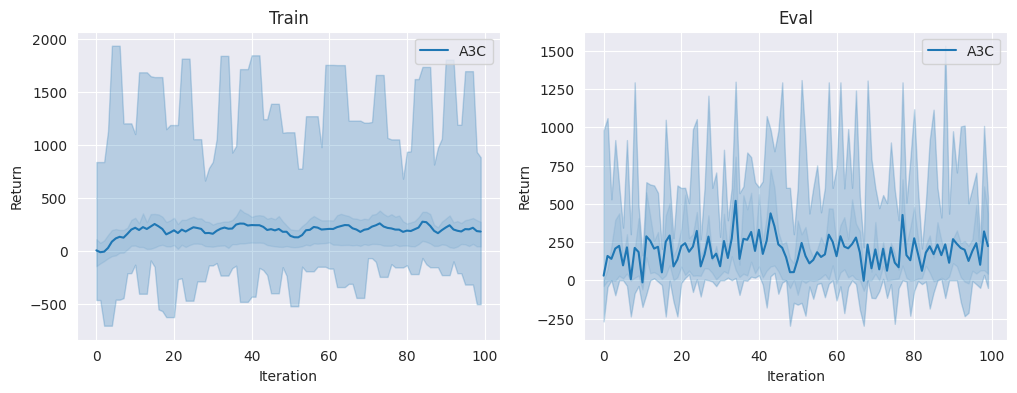

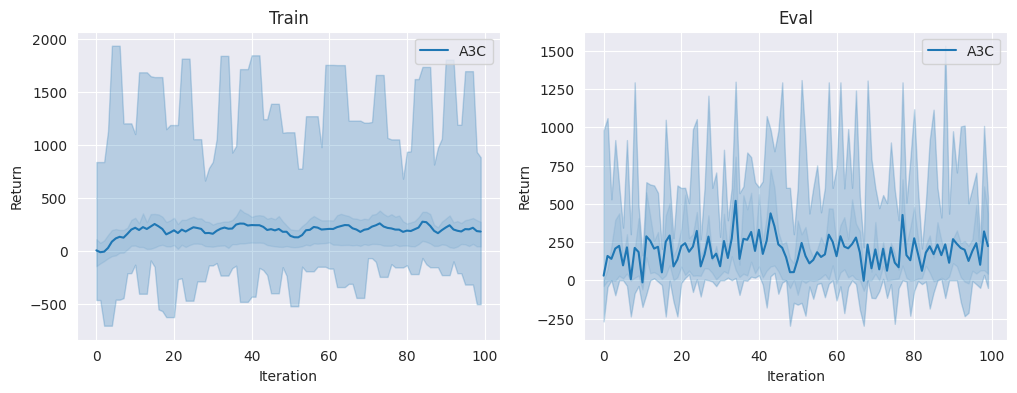

In [37]:
from ray.rllib.algorithms.a3c import A3CConfig
from ray.tune.registry import register_env

ray.shutdown()
ray.init()

register_env('StockExchangeEnv-v0', lambda config: StockExchangeEnv0(**config))


a3c = (
    A3CConfig()
    .training()
    .rollouts(num_rollout_workers=4, num_envs_per_worker=8)
    .resources(num_gpus=1)
    .environment(env='StockExchangeEnv-v0',
                 env_config={
                    'state_config': state_config,
                    '_n_days': 10
                 })
    .reporting(min_sample_timesteps_per_iteration=4 * 8 * 1440)
    .evaluation(
        evaluation_interval=20,
        evaluation_duration=10,
        evaluation_config={'explore': False}
    )
    .build()
)

run_single_experiment(a3c, 'A3C', 100)

## SAC

In [81]:
from ray.rllib.algorithms.sac import SACConfig
from ray.tune.registry import register_env

ray.shutdown()
ray.init()

register_env('StockExchangeEnv-v0', lambda config: StockExchangeEnv0(**config))


sac_config_base = (
    SACConfig()
    .rollouts(num_rollout_workers=1, num_envs_per_worker=8)
    .resources(num_gpus=1)
    .environment(env='StockExchangeEnv-v0',
                 env_config={
                    'state_config': state_config,
                     '_idxs_range': [288000]
                 })
    .reporting(min_sample_timesteps_per_iteration=8 * 1440)
    .evaluation(
        evaluation_interval=20,
        evaluation_duration=10,
        evaluation_config={'explore': False}
    )
)

configs = {
    '$\alpha=1.0$': sac_config_base.training(initial_alpha=1.0).build(),
    '$\alpha=0.5$': sac_config_base.training(initial_alpha=0.5).build(),
    '$\alpha=0.1$': sac_config_base.training(initial_alpha=0.1).build(),
    '$tanh$': sac_config_base.training(q_model_config={'fcnet_activation': 'tanh'}, policy_model_config={'fcnet_activation': 'tanh'}).build(),
}

run_multiple_experiments(configs, n_iterations=300)

2023-05-21 21:24:54,182	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(RolloutWorker pid=3529292) 2023-05-21 21:25:11,507	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-05-21 21:25:12,502	INFO trainable.py:172 -- Trainable.setup took 16.714 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(RolloutWorker pid=3531261) 2023-05-21 21:25:28,095	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-05-21 21:25:28,890	INFO trainable.py:172 -- Trainable.setup took 16.368 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(RolloutWorker pid=3533212) 2023-05-21 21:25:45,783	WARNING env.p

KeyboardInterrupt: 

In [83]:
sac = (
    SACConfig()
    .rollouts(num_rollout_workers=1, num_envs_per_worker=8)
    .resources(num_gpus=1)
    .environment(env='StockExchangeEnv-v0',
                 env_config={
                    'state_config': state_config,
                     '_idxs_range': [288000]
                 })
    .reporting(min_sample_timesteps_per_iteration=8 * 1440)
    .evaluation(
        evaluation_interval=20,
        evaluation_duration=10,
        evaluation_config={'explore': False}
    )
    .build()
)

sac.get_policy().model

(RolloutWorker pid=3301883) 2023-05-25 11:20:21,815	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-05-25 11:20:22,753	INFO trainable.py:172 -- Trainable.setup took 11.670 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


SACTorchModel(
  (action_model): FullyConnectedNetwork(
    (_logits): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=3, bias=True)
      )
    )
    (_hidden_layers): Sequential(
      (0): SlimFC(
        (_model): Sequential(
          (0): Linear(in_features=17, out_features=256, bias=True)
          (1): ReLU()
        )
      )
      (1): SlimFC(
        (_model): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): ReLU()
        )
      )
    )
    (_value_branch): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=1, bias=True)
      )
    )
  )
  (q_net): FullyConnectedNetwork(
    (_logits): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=3, bias=True)
      )
    )
    (_hidden_layers): Sequential(
      (0): SlimFC(
        (_model): Sequential(
          (0): Linear(in_features=17, out_features=256, bias=True)
          

In [19]:
env = StockExchangeEnv0(
    state_config={
        'market_state': ['vwap'],
        'technical_indicators': [
            (EMA, dict(timeperiod=5, normalize=True), '1min'),
            (EMA, dict(timeperiod=13, normalize=True), '1min'),
            (RSI, dict(timeperiod=7, normalize=True), '1min'),
            (BBANDS, dict(timeperiod=10), '1min'),
            (EMA, dict(timeperiod=20, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1h'),
            (RSI, dict(timeperiod=14, normalize=True), '1h'),
            (BBANDS, dict(timeperiod=20), '1h'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1d'),
            (EMA, dict(timeperiod=200, normalize=True), '1d'),
            (RSI, dict(timeperiod=14, normalize=True), '1d'),
            (BBANDS, dict(timeperiod=20), '1d'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1d'),
        ]},
    _idxs_range=[2702678]
)

# Seed 52: 29 Oct, 2022
state, done = env.reset()[0], False
while not done:
    env.render()
    state, reward, done, _, _ = env.step(0)

KeyboardInterrupt: 

amount      214.853370
price     20730.097315
Name: 1667030820, dtype: float64